<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/06_Transfer_Learning_Part3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Thu Mar 25 21:55:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Transfer Learning with TensorFlow - Scaling Up 
We've seen the power of transfer learning feature extraction and fine-tuning now it's time to scale up to all of the classes in Food101 (101 classes). 

Our goal is to beat original Food101 paper with 10% of the training data, leveraging the power of the transfer learning. Our baseline is to beat 50.76% accuracy across 101 classes.

### Thing's to cover 
- Downloading $ preparing 10% of all Food101 classes (7500+ training images). 
- Training a **transfer learning feature extraction** model. 
- Fine-tuning our feature extraction model(👁 Food Vision mini) to beat the original Food101 paper with only 10% of the data. 
- Evaluating Food Vision mini's predictions. 
  - Finding the most wrong prediction (on the test data). 
- Making **predictions with the Food Vision mini on our custom images**.



## Creating Helper function 
In previous notebook, we've created a series of helper function to do different tasks, let's download them.

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-03-25 21:55:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-03-25 21:55:59 (79.7 MB/s) - ‘helper_functions.py’ saved [9304/9304]



In [4]:
# Import series of helper function for our notebook 
from helper_functions import  create_tensorboard_callback , unzip_data , plot_loss_curves , compare_historys , walk_through_dir

## 101 Food Classes: workking with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it. 

The data we're downloading comes from original Food101 dataset but has been preprocessed using the `image_data_modification.ipynb`

In [5]:
# Getting the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2021-03-25 21:56:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   151MB/s    in 8.9s    

2021-03-25 21:56:10 (174 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# How many images classes are there 
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_

In [7]:
# Setup data inputs 
import tensorflow as tf
IMG_SIZE = (224 , 224)

# Loading in the data
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir , 
                                                                                image_size = IMG_SIZE , 
                                                                                batch_size = 32 , 
                                                                                label_mode = 'categorical') 

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir , 
                                                                label_mode = 'categorical' , 
                                                                image_size = IMG_SIZE, 
                                                                shuffle = False) # don't shuffle data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
print('Hello World')

Hello World


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take: 
- Create a `ModelCheckpoint` callback.
- Create **data augmentation layer** to build data augmentation right into the model. 
- Build a headless (no top layers) Functional EfficientNet B0 backboned-model(we'll create our own output layer). 
- Compile our model 
- Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data to save epoch time). 

In [9]:
# Create checkpoint callback 
checkpoint_path = '101_food_classes_10_percent_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path , 
                                                         monitor = 'val_accuracy' ,  # stores higher accuracy
                                                         save_weights_only = True )

In [10]:
# Create data augmentation layer to incorporate it right into the model 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augmentation 
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomWidth(0.2), 
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2) , 
  preprocessing.RandomZoom(0.2)
] , name = 'data_augmentation_layer')


In [11]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # backboned-model

# Freezing the base model (freeze all of the patterns)
base_model.trainable = False

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape = (224 , 224, 3) ,name = 'input_layer')
x = data_augmentation(inputs) # Augment images only happens during training 
x = base_model(x , training = False) # puts the base model in inference mode so weights which need to stay frozen, stays frozen
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pool_2D_layer')(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names) , activation='softmax' , name = 'output_layer')(x)

# Packing into a model 
model = tf.keras.Model(inputs , outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [12]:
# Checking the summary of the model 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool_2D_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
# Compile the model 
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['accuracy'])

In [14]:
# Fitting the model 
history_all_class_10_percent = model.fit(train_data_all_10_percent , 
                                         epochs = 5 , 
                                         validation_data = test_data , 
                                         validation_steps = int(0.25 * len(test_data)) , 
                                         callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 139s 432ms/step - loss: 3.9818 - accuracy: 0.1475 - val_loss: 2.7736 - val_accuracy: 0.3507
Epoch 2/5
237/237 [==============================] - 86s 363ms/step - loss: 2.4114 - accuracy: 0.4574 - val_loss: 2.2730 - val_accuracy: 0.4415
Epoch 3/5
237/237 [==============================] - 81s 342ms/step - loss: 1.9746 - accuracy: 0.5386 - val_loss: 2.1022 - val_accuracy: 0.4686
Epoch 4/5
237/237 [==============================] - 76s 318ms/step - loss: 1.7702 - accuracy: 0.5745 - val_loss: 1.9895 - val_accuracy: 0.4838
Epoch 5/5
237/237 [==============================] - 75s 316ms/step - loss: 1.6019 - accuracy: 0.6099 - val_loss: 1.9726 - val_accuracy: 0.4775


In [15]:
# Let's evaluate on the whole test data 
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 100s 127ms/step - loss: 1.7039 - accuracy: 0.5575


After we evaluated our model on the whole test set, we got a accuracy of **`55%`** and we beat the paper!!! 

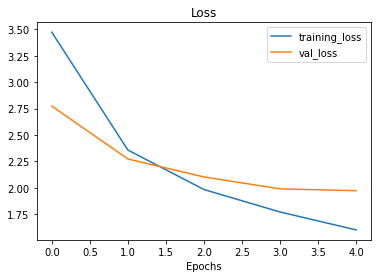

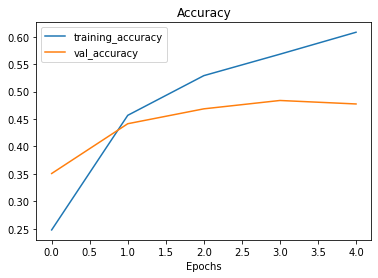

In [16]:
# Let's watch the loss curves 
plot_loss_curves(history_all_class_10_percent)

> **Question** What do these curves suggest? 
Ideally, the two curves should be similar to each other if not.. Overfitting!

They should be close to eachother, it seems if we are gonna train for more epochs our results might get worse as we train for more epochs. 

## Fine-tuning 

In [17]:
# Unfreeze all of the layers in the base model
base_model.trainable = True 

# Refreeze every layer except the last 5 
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
# Compile the model (it's best practice to lower the learning rate when fine-tuning)
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001) , # learning rate lowered
              metrics = ['accuracy'])

In [19]:
# What layers in the model are trainable 
for layer in model.layers:
  print(layer.name , layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pool_2D_layer True
output_layer True


In [20]:
# Check which layers are trainable in our base_model 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name , layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [21]:
# Fitting our model and fine_tuning it
initial_epochs = 5 
fine_tune_epochs = initial_epochs + 5
history_all_classes_fine_tune_10_percent = model.fit(train_data_all_10_percent , 
                                                     epochs = fine_tune_epochs , 
                                                     validation_data = test_data , 
                                                     validation_steps = int(0.15 * len(test_data)) , 
                                                     initial_epoch = history_all_class_10_percent.epoch[-1] )

Epoch 5/10
237/237 [==============================] - 70s 275ms/step - loss: 1.4092 - accuracy: 0.6481 - val_loss: 1.9302 - val_accuracy: 0.5005
Epoch 6/10
237/237 [==============================] - 60s 252ms/step - loss: 1.2471 - accuracy: 0.6771 - val_loss: 1.9187 - val_accuracy: 0.4997
Epoch 7/10
237/237 [==============================] - 59s 247ms/step - loss: 1.1661 - accuracy: 0.6913 - val_loss: 1.8892 - val_accuracy: 0.5082
Epoch 8/10
237/237 [==============================] - 58s 243ms/step - loss: 1.1044 - accuracy: 0.7081 - val_loss: 1.8863 - val_accuracy: 0.5114
Epoch 9/10
237/237 [==============================] - 58s 243ms/step - loss: 1.0305 - accuracy: 0.7278 - val_loss: 1.9257 - val_accuracy: 0.5016
Epoch 10/10
237/237 [==============================] - 57s 240ms/step - loss: 0.9833 - accuracy: 0.7387 - val_loss: 1.9001 - val_accuracy: 0.5066


In [22]:
history_all_class_10_percent.epoch[-1]

4

In [23]:
# Evaluate on the whole test data 
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 99s 126ms/step - loss: 1.5985 - accuracy: 0.5806


In [24]:
# Results for feature extraction 
feature_extraction_results

[1.7039433717727661, 0.5575049519538879]

Hmm, there isn't a much difference. After fine-tuning the accuracy increased only by 2%. 

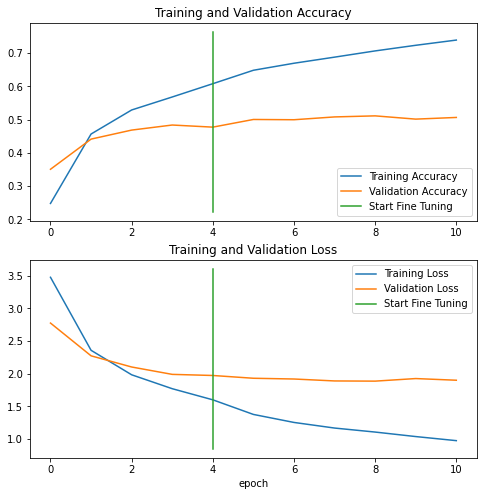

In [26]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(history_all_class_10_percent , 
                 history_all_classes_fine_tune_10_percent , 
                 initial_epochs = 5)

Observing the plot, it seems our model is overfitting on the training data. 

## Improving the model 
In here I will give my best to try and improve the model. Let's see how it goes...

The following experiments will be: 
- `model_exp_1` --> With fewer data augmentation layers (0-3), run for more epochs and see how it turns out. 
- `model_exp_2` --> Same fewer layers but tweak the values in that , run for more epochs. 
- `model_exp_3` --> Add more data augmentation layers with default values, run for 5 epochs. 
- `model_exp_4` --> Add more data augmentation layers with default values, run for more epochs. 
- `model_exp_5` --> Fewer data augmentation layer with tweaking values, run for more epochs. 

Will work with `interpolation = 'nearest'` for two experiments if the results aren't good will change it back to `bilinear`

In [50]:
# Creating a callback for our experimentation 
checkpoint_path_exp = '101_food_classes_improving_model'

checkpoint_callback_exp = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path_exp , 
                                                             save_weights_only = True , 
                                                             save_best_only = False , 
                                                             save_freq = 'epoch' , 
                                                             verbose = 1 , 
                                                             monitor ='val_accuracy')

In [ ]:
# Checking what's in our data 
walk_through_dir('/content/101_food_classes_10_percent')

In [36]:
# Now let's check what was the previous accuracy we gotta beat
print(f'This is the accuracy we gotta beat: {all_classes_10_percent_fine_tune_results[1]:.3%}')

This is the accuracy we gotta beat: 58.063%


In [37]:
# Let's import our data
BATCH_SIZE = 32
INTERPOLATION = 'nearest'
train_data_exp_1 = tf.keras.preprocessing.image_dataset_from_directory(train_dir , 
                                                                       image_size = IMG_SIZE , 
                                                                       batch_size = BATCH_SIZE , 
                                                                       interpolation = INTERPOLATION , 
                                                                       shuffle = True , 
                                                                       label_mode = 'categorical')

Found 7575 files belonging to 101 classes.


We already have test data, only making changes in the **train_data**


#### `model_exp_1` With fewer data augmentation layers (0-3), run for more epochs and see how it turns out (EfficientNet B1)

In [101]:
# Now let's work on constructing our data augmentation layer 
# Fewer data augmentation layers
data_augmentation_exp_1 = Sequential([
  preprocessing.RandomFlip(), # default horiz and vertical
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.3)
])

In [102]:
# Now contructing a feature extraction model 

# Input shape 
inputs = layers.Input(shape=(224 , 224 , 3) , name = 'input_layer')

# Creating the base model (back-boned one)
base_model = tf.keras.applications.EfficientNetB1(include_top= False)
# Freezing all the layers 
base_model.trainable = False 

# Adding our data augmentation layer
x = data_augmentation_exp_1(inputs) 

# Now time for our base_model into action 
x = base_model(x , training = False)

# Condensing the tensors out from our base_model 
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_2D_layer')(x)

# Dense layer with our output classes 
outputs = layers.Dense(len(train_data_exp_1.class_names) , activation ='softmax',name = 'output_layer')(x)

# Wrapping in a model 
model_exp_1 = tf.keras.Model(inputs , outputs)

In [103]:
# Checking the summary of our model 
model_exp_1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, None, None, 1280)  6575239   
_________________________________________________________________
global_average_pooling_2D_la (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 6,704,620
Trainable params: 129,381
Non-trainable params: 6,575,239
_________________________________________________________________


In [104]:
# Let's compile and fit the extraction model for 5 epochs 
model_exp_1.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                    optimizer = tf.keras.optimizers.Adam(), 
                    metrics = ['accuracy'])

history_exp_extractor_1 = model_exp_1.fit(train_data_exp_1 , 
                                          epochs = 5 , 
                                          validation_data = test_data , 
                                          validation_steps = int(0.25 * len(test_data)) , 
                                       callbacks = [checkpoint_callback_exp])

Epoch 1/5
237/237 [==============================] - 78s 301ms/step - loss: 4.1042 - accuracy: 0.1260 - val_loss: 2.7568 - val_accuracy: 0.3867

Epoch 00001: saving model to 101_food_classes_improving_model
Epoch 2/5
237/237 [==============================] - 71s 295ms/step - loss: 2.6202 - accuracy: 0.4122 - val_loss: 2.2860 - val_accuracy: 0.4553

Epoch 00002: saving model to 101_food_classes_improving_model
Epoch 3/5
237/237 [==============================] - 71s 296ms/step - loss: 2.1922 - accuracy: 0.4809 - val_loss: 2.1261 - val_accuracy: 0.4678

Epoch 00003: saving model to 101_food_classes_improving_model
Epoch 4/5
237/237 [==============================] - 71s 295ms/step - loss: 1.9729 - accuracy: 0.5301 - val_loss: 2.0057 - val_accuracy: 0.4835

Epoch 00004: saving model to 101_food_classes_improving_model
Epoch 5/5
237/237 [==============================] - 71s 296ms/step - loss: 1.8394 - accuracy: 0.5476 - val_loss: 1.9603 - val_accuracy: 0.4924

Epoch 00005: saving model t

In [105]:
# Check which layers are tuneable in the base model 
for layer_number , layer in enumerate(model_exp_1.layers):
  print(layer_number , layer.name , layer.trainable)

0 input_layer True
1 sequential_2 True
2 efficientnetb1 False
3 global_average_pooling_2D_layer True
4 output_layer True


In [106]:
# Now it's time to unfreeze the last 5 or so layers and fine tune the model 

# Unfreezing all layer 
base_model.trainable = True

# Re-Freeze all layers except except for the 
for layer in base_model.layers[:-5]: 
  layer.trainable = False

In [107]:
# Making changes by compiling the model 
model_exp_1.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                    optimizer = tf.keras.optimizers.Adam(lr = 0.0001) , 
                    metrics = ['accuracy'])

In [108]:
# Now it's again time to check which models are trainable (EfficientNet should be True)
for layer in model_exp_1.layers:
  print(layer.name , layer.trainable)

input_layer True
sequential_2 True
efficientnetb1 True
global_average_pooling_2D_layer True
output_layer True


In [109]:
# Cool! Let's get into our base model and see what layers are exactly trainable 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name , layer.trainable)

0 input_9 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_s

In [110]:
# Fine tuning our model 
fine_tune_epochs = initial_epochs + 5 

# Refit the model 
history_fine_tune_exp1 = model_exp_1.fit(train_data_exp_1 , 
                                         epochs = fine_tune_epochs , 
                                         validation_data = test_data , 
                                         validation_steps = int( 0.25 * len(test_data)) , 
                                         initial_epoch = history_exp_extractor_1.epoch[-1] , 
                                         callbacks = [checkpoint_callback_exp])

Epoch 5/10
237/237 [==============================] - 79s 303ms/step - loss: 1.6590 - accuracy: 0.5895 - val_loss: 1.8921 - val_accuracy: 0.5048

Epoch 00005: saving model to 101_food_classes_improving_model
Epoch 6/10
237/237 [==============================] - 71s 298ms/step - loss: 1.5431 - accuracy: 0.6167 - val_loss: 1.8720 - val_accuracy: 0.5071

Epoch 00006: saving model to 101_food_classes_improving_model
Epoch 7/10
237/237 [==============================] - 72s 300ms/step - loss: 1.4483 - accuracy: 0.6269 - val_loss: 1.8540 - val_accuracy: 0.5132

Epoch 00007: saving model to 101_food_classes_improving_model
Epoch 8/10
237/237 [==============================] - 71s 298ms/step - loss: 1.3970 - accuracy: 0.6366 - val_loss: 1.8387 - val_accuracy: 0.5162

Epoch 00008: saving model to 101_food_classes_improving_model
Epoch 9/10
237/237 [==============================] - 72s 301ms/step - loss: 1.3347 - accuracy: 0.6681 - val_loss: 1.8267 - val_accuracy: 0.5174

Epoch 00009: saving mo

In [111]:
# Now testing on the whole test data
model_exp_1_results = model_exp_1.evaluate(test_data)

790/790 [==============================] - 117s 148ms/step - loss: 1.5732 - accuracy: 0.5821


In [112]:
all_classes_10_percent_fine_tune_results

[1.5985146760940552, 0.5806336402893066]

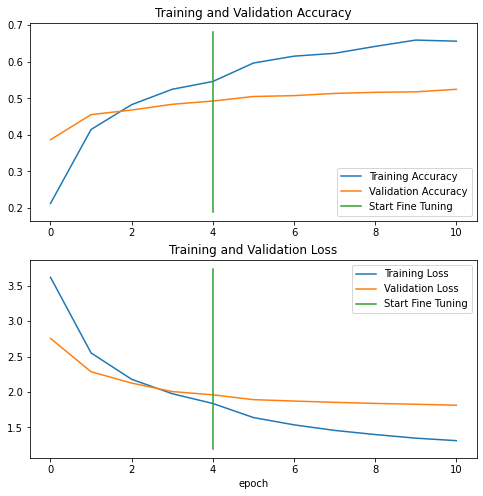

In [113]:
# Let's plot loss curves 
compare_historys(history_exp_extractor_1 , 
                 history_fine_tune_exp1 , 
                 initial_epochs = 5)

Hmm.. There is no much improvement. As we can see the validation accuracy getting worse as we train for more epochs. Let's try another experimentation with different model settings and by adding more augmentation layers and setting `interpolation = 'bilinear'`